# Статистический анализ данных: анализ сервиса аренды самокатов GoFast

**Исследование данных по аренде самокатов. Вступление**

**Заказчик** этого исследования — сервис аренды самокатов GoFast.<br><br>
**Цель проекта:**
- проанализировать данные аренды самокатов 
- проверить гипотезы, направленные на улучшение и рост эффективности сервиса. 

**Описание данных:**<br>
данные содержат информацию о пользователях, их поездках и подписках.
Данные содержатся в 3 csv-файлах: users_go, rides_go, subscriptions_go.

**План работ:**<br>
- загрузить данные
- предобработать данные: преобразовать типы, заполнить пропуски, обработать дубликаты.
- исследовать общую информацию о пользователях и поездках: .
- объединить данные и визуализировать информацию.
- рассчитать помесячную выручку, которую принес каждый пользователь.
- проверить гипотезы:
    - тратят ли пользователи с подпиской больше времени на поездки
    - среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров
    - будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

#### Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv("/datasets/users_go.csv")
rides = pd.read_csv("/datasets/rides_go.csv")
subscriptions = pd.read_csv("/datasets/subscriptions_go.csv")

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [7]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Данные полные и правильных типов, за исключением даты в таблице rides.

#### Шаг 2. Предобработка данных

In [9]:
rides['date'] = pd.to_datetime(rides['date'], format = '%Y-%m-%d')

In [10]:
rides['month_num'] = rides['date'].dt.month

##### Проверка на наличие нулевых значений в таблицах

In [11]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [12]:
rides.isna().sum()

user_id      0
distance     0
duration     0
date         0
month_num    0
dtype: int64

Нулевых значений в таблицах нет.

##### Проверка на наличие дубликатов

In [13]:
users.duplicated().sum()

31

В таблице users есть 31 строка - явные дубликаты, посмотрим подробнее эти строки и затем удалим.

In [14]:
users[users['user_id'].isin(users[users['user_id'].duplicated() == True]['user_id'])].sort_values(by='user_id')

,user_id,name,age,city,subscription_type
15,16,Амалия,27,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
42,43,Стефания,22,Омск,ultra
1539,43,Стефания,22,Омск,ultra
1563,47,Юрий,28,Тюмень,ultra
...,...,...,...,...,...
1554,1198,Демид,29,Ростов-на-Дону,free
1558,1237,Евгения,23,Тюмень,free
1236,1237,Евгения,23,Тюмень,free
1544,1245,Регина,27,Пятигорск,free


In [15]:
users = users.drop_duplicates()

In [16]:
users.duplicated().sum()

0

Дубликатов в таблице users не осталось.

In [17]:
rides.duplicated().sum()

0

Дубликатов в таблицах rides и subscriptions нет.

#### Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов

In [18]:
users.pivot_table(index = 'city', aggfunc = 'count')['user_id'].sort_values(ascending = False)

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: user_id, dtype: int64

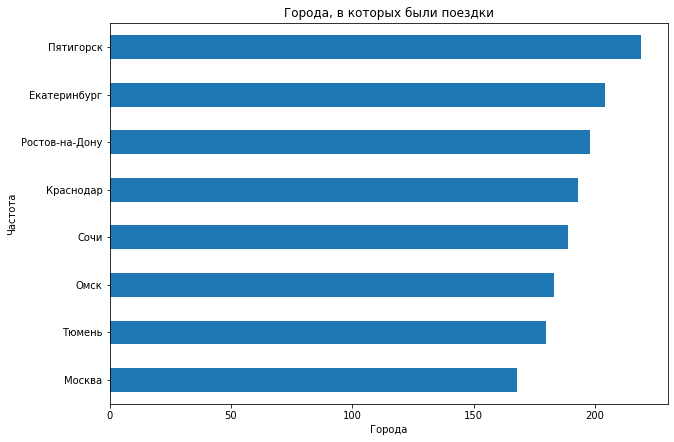

In [19]:
users.pivot_table(index = 'city', aggfunc = 'count')['user_id'].sort_values().plot(title='Города, в которых были поездки', kind='barh', figsize = (10,7), legend = False)
plt.xlabel("Города");
plt.ylabel("Частота");


Больше всего пользователей сервиса GoFast в городах: Пятигорск, Екатеринбург, Ростов-на-Дону.<br> Сервис работаетв 8 городах.<br> При этом Москва оказалась на последнем месте. Возможно там много сервисов-конкурентов. 

##### Соотношение пользователей с подпиской и без подписки

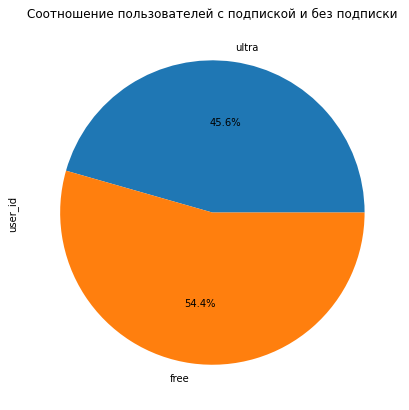

In [20]:
users.pivot_table(index = 'subscription_type', aggfunc = 'count')['user_id'].sort_values().plot(title='Соотношение пользователей с подпиской и без подписки', kind='pie', figsize = (10,7),  autopct='%1.1f%%', legend = False);


Пользователей без подписки больше, чем пользователей с подпиской, приблизительно на 10%.

##### Возраст пользователей

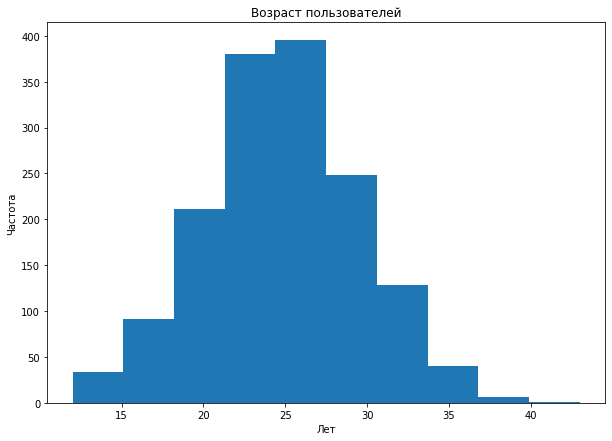

In [21]:
users.plot(y='age',title='Возраст пользователей', kind='hist' ,bins=10, figsize = (10,7), legend = False)
plt.xlabel("Лет");
plt.ylabel("Частота");

In [22]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Средний и медианный возраст пользователей примерно 25 лет. В основном сервисом пользуются молодые люди от 22 до 28 лет.<br>
Минимальный возраст составил 12 лет, максимальный 43 года.

##### Расстояние, которое пользователь преодолел за одну поездку

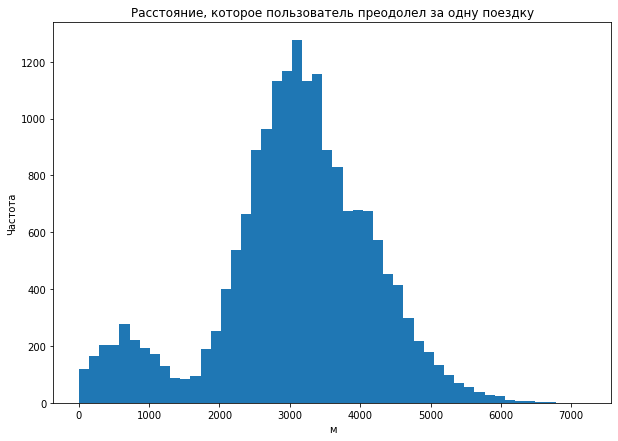

In [23]:
rides.plot(y='distance',title='Расстояние, которое пользователь преодолел за одну поездку', kind='hist' ,bins=50, figsize = (10,7), legend = False)
plt.xlabel("м");
plt.ylabel("Частота");

In [24]:
rides.describe()

,user_id,distance,duration,month_num
count,18068.000000,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011,6.486772
std,434.734317,1116.831209,6.091051,3.437410
min,1.000000,0.855683,0.500000,1.000000
25%,487.000000,2543.226360,13.597563,4.000000
50%,889.000000,3133.609994,17.678395,6.000000
75%,1213.250000,3776.222735,21.724800,9.000000
max,1534.000000,7211.007745,40.823963,12.000000


Средняя дистанция составляет 3070м, тогда как медианная - 3133 м, значит есть некоторые всплески.<br>
В основном за 1 поездку пользователи проезжают от 2500 до 3700 м.<br>

Увеличив интервалы, видим, что также имеется всплеск слева - расстояния около **500м**.<br>Он может быть вызван тем, что пользователи добираются до метро или удобного транспорта на самокате, при этом получаются небольшие поездки.<br>Или просто пробуют сервис.

##### Продолжительность поездок

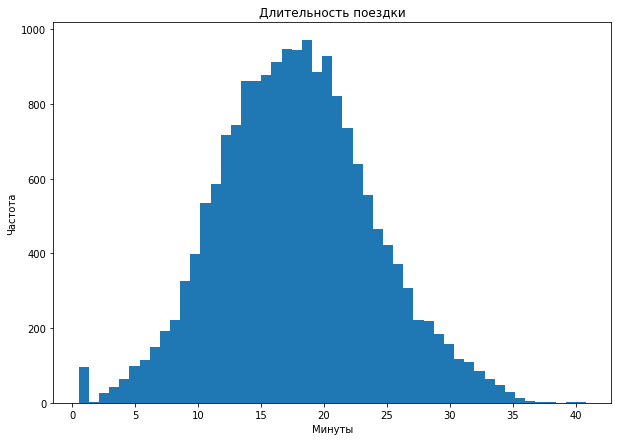

In [25]:
rides.plot(y='duration',title='Длительность поездки', kind='hist' ,bins=50, figsize = (10,7), legend = False)
plt.xlabel("Минуты");
plt.ylabel("Частота");

Среднее и медианное время поездки составляют 17,7 мин. В основном пользователи совершают поездку за время от 14 до 22 минут. Максимум составил 40 минут.

#### Шаг 4. Объединение данных

In [26]:
data = users.merge(rides, on = 'user_id').merge(subscriptions, on = 'subscription_type')

In [27]:
data.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month_num,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month_num          18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


In [29]:
data.isnull().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month_num            0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

В новой объединенной таблице **18068 строк**, пропусков нет ни в одном столбце.<br>
Также количество строк новой таблицы совпадает с количеством строк таблицы о поездках rides.<br>
В связи с этим можем утверждать, что **объединение прошло корректно**.

In [30]:
data_ultra = data.query('subscription_type == "ultra"')

In [31]:
data_free = data.query('subscription_type == "free"')

In [32]:
data_ultra.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month_num,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


In [33]:
data_free.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month_num,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
6505,700,Айдар,22,Омск,free,4342.002254,22.368009,2021-02-23,2,8,50,0
6506,700,Айдар,22,Омск,free,3798.334905,18.243756,2021-03-03,3,8,50,0
6507,700,Айдар,22,Омск,free,2984.551206,15.424899,2021-04-09,4,8,50,0
6508,700,Айдар,22,Омск,free,3360.107141,16.765497,2021-06-12,6,8,50,0
6509,700,Айдар,22,Омск,free,2567.543847,11.312160,2021-06-23,6,8,50,0


In [34]:
len(data_ultra)

6500

In [35]:
len(data_free)

11568

In [36]:
if len(data) == len(data_ultra) + len(data_free):
    print('Количество строк в полученных таблицах составляет совокупный размер исходной таблицы')
else:
    print('Необходимо проверить запросы')

Количество строк в полученных таблицах составляет совокупный размер исходной таблицы


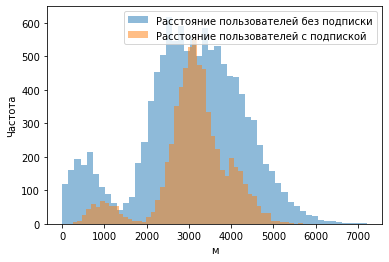

In [37]:
plt.hist(data_free['distance'], alpha = 0.5, bins=50,  label = 'Расстояние пользователей без подписки')
plt.hist(data_ultra['distance'], alpha = 0.5,  bins=50, label = 'Расстояние пользователей с подпиской')
plt.legend(loc='upper right')
plt.xlabel("м");
plt.ylabel("Частота");
plt.show()

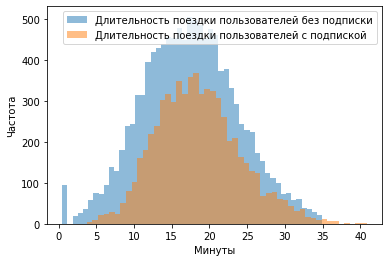

In [38]:
plt.hist(data_free['duration'], alpha = 0.5, bins=50,  label = 'Длительность поездки пользователей без подписки')
plt.hist(data_ultra['duration'], alpha = 0.5,  bins=50, label = 'Длительность поездки пользователей с подпиской')
plt.legend(loc='upper right')
plt.xlabel("Минуты");
plt.ylabel("Частота");
plt.show()

Видно, что короткие поездки совершают в основном пользователи без подписки.

In [39]:
data_ultra.describe()

,user_id,age,distance,duration,month_num,minute_price,start_ride_price,subscription_fee
count,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.0,6500.0,6500.0
mean,348.725385,24.892615,3115.445388,18.541985,6.422308,6.0,0.0,199.0
std,201.099339,4.757208,836.895330,5.572048,3.414616,0.0,0.0,0.0
min,1.000000,12.000000,244.210438,3.760353,1.000000,6.0,0.0,199.0
25%,175.000000,22.000000,2785.444017,14.524654,4.000000,6.0,0.0,199.0
50%,351.000000,25.000000,3148.637229,18.178153,6.000000,6.0,0.0,199.0
75%,525.000000,28.000000,3560.574425,21.884129,9.000000,6.0,0.0,199.0
max,699.000000,38.000000,5699.769662,40.823963,12.000000,6.0,0.0,199.0


In [40]:
data_free.describe()

,user_id,age,distance,duration,month_num,minute_price,start_ride_price,subscription_fee
count,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.0,11568.0,11568.0
mean,1120.527230,24.893326,3045.495282,17.390909,6.522994,8.0,50.0,0.0
std,241.165628,4.481100,1246.173806,6.326803,3.449770,0.0,0.0,0.0
min,700.000000,12.000000,0.855683,0.500000,1.000000,8.0,50.0,0.0
25%,915.000000,22.000000,2366.562689,12.958437,4.000000,8.0,50.0,0.0
50%,1123.000000,25.000000,3114.648465,17.326890,7.000000,8.0,50.0,0.0
75%,1328.000000,28.000000,3905.697894,21.594071,9.000000,8.0,50.0,0.0
max,1534.000000,43.000000,7211.007745,34.948498,12.000000,8.0,50.0,0.0


**Дистанция:**
У пользователей без подписки больший разброс расстояния, на которое совершается поездка.<br>
Также пользователи без подписки чаще совершают небольшие поездки.
Пользователи сподпиской в основном проезжают от 2800 до 3500 м, тогда как пользователи без подписки от 2400 до 3900 м.
В целом графики похожи, но колокол для пользователей без подписки шире.

**Длительность**: У пользователей без подписки также наблюдается больший разброс.<br>
В основном без подписки проезжают от 13 до 22 минут, без подписки от 15 до 22 минут.<br>
Средняя продолжительность составляет: без подписки 17 минут, с подпиской 18 минут.<br>
Распределения продолжительности поездки в целом похожи.
    

#### Шаг 5. Подсчёт выручки

In [41]:
data['duration'] = np.ceil(data['duration'])

In [42]:
data_info = data.pivot_table(index = ['user_id', 'name', 'age', 'city', 'subscription_type', 'month_num'], values = ['distance', 'duration'], aggfunc = ['sum', 'count'])

In [43]:
data_info.columns = ['distanse_sum', 'duration_sum', 'rides_count', 'rides']

In [44]:
data_info = data_info.drop(columns = 'rides')

In [45]:
data_info.head(10)

distanse_sum  \
user_id name      age city   subscription_type month_num                 
1       Кира      22  Тюмень ultra             1           7027.511294   
                                               4            754.159807   
                                               8           6723.470560   
                                               10          5809.911100   
                                               11          7003.499363   
                                               12          6751.629942   
2       Станислав 31  Омск   ultra             3          10187.723006   
                                               4           6164.381824   
                                               6           3255.338202   
                                               7           6780.722964   

                                                          duration_sum  \
user_id name      age city   subscription_type month_num                 
1       Кира      22  Тюмень ultra             1                  42.0   
                                               4                   7.0   
                                               8                  46.0   
                                               10                 32.0   
                                               11                 56.0   
                                               12                 28.0   
2       Станислав 31  Омск   ultra             3                  63.0   
                                               4                  40.0   
                                               6                  14.0   
                                               7                  48.0   

                                                          rides_count  
user_id name      age city   subscription_type month_num               
1       Кира      22  Тюмень ultra             1                    2  
                                               4                    1  
                                               8                    2  
                                               10                   2  
                                               11                   3  
                                               12                   2  
2       Станислав 31  Омск   ultra             3                    3  
                                               4                    2  
                                               6                    1  
                                               7                    2

In [46]:
data['date'].dt.year.unique()

array([2021])

In [47]:
data_info = data_info.merge(subscriptions, on = 'subscription_type')

In [48]:
data_info['month_income'] = data_info['start_ride_price']*data_info['rides_count'] + data_info['minute_price']*data_info['duration_sum'] + data_info['subscription_fee']

In [49]:
data_info

,subscription_type,distanse_sum,duration_sum,rides_count,minute_price,start_ride_price,subscription_fee,month_income
0,ultra,7027.511294,42.0,2,6,0,199,451.0
1,ultra,754.159807,7.0,1,6,0,199,241.0
2,ultra,6723.470560,46.0,2,6,0,199,475.0
3,ultra,5809.911100,32.0,2,6,0,199,391.0
4,ultra,7003.499363,56.0,3,6,0,199,535.0
...,...,...,...,...,...,...,...,...
11326,free,3409.468534,26.0,2,8,50,0,308.0
11327,free,7622.453034,48.0,2,8,50,0,484.0
11328,free,4928.173852,23.0,1,8,50,0,234.0
11329,free,13350.015305,78.0,4,8,50,0,824.0


Подсчитали **помесячную выручку**, которую приносит сервису каждый пользователь.<br>
Для этого:
- округлили до целого пройденную дистанцию каждой поездки
- создали сводную таблицу, рассчитав для каждого пользователя помесячно пройденную дистанцию, продолжительность и количество поездок.
- применили формулу: *стоимость старта поездки × количество поездок + стоимость одной минуты поездки × общая продолжительность всех поездок в минутах + стоимость подписки.*

#### Шаг 6. Проверка гипотез

##### Тратят ли пользователи с подпиской больше времени на поездки

Нулевая гипотеза: среднее значение продолжительности поездки пользователей с подпиской равно среднему значению продолжительности поездки пользователей без подписки<br>
Альтернативная гипотеза: среднее значение продолжительности поездки пользователей с подпиской больше среднего пользователей без подписки<br>
У нас две независимые выборки, в связи с этим используем *ttest_ind*

In [50]:
print('Средняя продолжительность поездки пользователей без подписки', np.mean(data_free['duration']))
print('Средняя продолжительность поездки пользователей c подпиской', np.mean(data_ultra['duration']))
# выбранный уровень статистической значимости 0,05
alpha = 0.01
results = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative = 'greater')
print('p-value', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Средняя продолжительность поездки пользователей без подписки 17.39090929866399
Средняя продолжительность поездки пользователей c подпиской 18.54198516280583
p-value 1.2804098316645618e-34
Отвергаем нулевую гипотезу


p-value достаточно мало. <br>
Нулевая гипотеза о том, что среднее значение продолжительности поездки пользователей без подписки и с подпиской равны, отвергнута.<br>
Есть основания утверждать, что средняя продолжительность поездки пользователей с подпиской больше.

##### Расстояние одной поездки в 3130 метров

Нулевая гипотеза: пользователи с подпиской проезжают в среднем 3130 м за одну поездку<br>
Альтернативная гипотеза: пользователи с подпиской проезжают в среднем более 3130м<br>
Проверяем одну выборку, поэтому используем *ttest_samp*

In [51]:
print('Средняя поездка пользователей c подпиской', np.mean(data_ultra['distance']))
# выбранный уровень статистической значимости 0,05
alpha = 0.01
results = st.ttest_1samp(data_ultra['distance'], 3130, alternative = 'greater')
print('p-value', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Средняя поездка пользователей c подпиской 3115.4453880370247
p-value 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу о том, что пользователи с подпиской проезжают в среднем 3130 м за одну поездку, отвергнуть не получилось.<br>
Есть основания полагать, что износ самокатов не выходит за границы оптимального и издержки тоже.

##### Помесячная выручка от пользователей

Нулевая гипотеза: среднее значение выручки от пользователей с подпиской равно среднему значению выручки от пользователей без подписки<br>
Альтернативная гипотеза: среднее значение помесячной выручки от пользователей с подпиской больше, чем от пользователей без подписки<br>
Проверяем две независимые выборки, поэтому используем *ttest_ind*

In [52]:
data_info_free = data_info.query('subscription_type == "free"')
data_info_ultra = data_info.query('subscription_type == "ultra"')

In [53]:
print('Средняя выручка от пользователей без подписки', np.mean(data_info_free['month_income']))
print('Средняя выручка от пользователей c подпиской', np.mean(data_info_ultra['month_income']))
# выбранный уровень статистической значимости 0,05
alpha = 0.01
results = st.ttest_ind(data_info_ultra['month_income'], data_info_free['month_income'], alternative = 'greater')
print('p-value', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Средняя выручка от пользователей без подписки 328.6413651073845
Средняя выручка от пользователей c подпиской 362.7921906022502
p-value 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Нулевая гипотеза о равенстве средних значений помесячной выручки пользователей с подпиской и без подписки отвергнута.<br>
Есть основания полагать, что помесячная выручка от пользователей с подпиской выше.

##### Влияет ли обновление серверов на количество обращений в поддержку?

Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него.

Здесь будет **двухвыборочный tтест для зависимых выборок: ttest_rel.**<br>
Нулевая гипотеза: среднее количество обращений после обновления сервера равно среднему значению количества обращений до обновления.<br>
Альтернативная гипотеза односторонняя: среднее количество обращений после обновления ниже, чем до обновления.

#### Вывод

##### Загрузка данных

Провели исследование данных сервиса аренды самокатов GoFast.<br>
Для этого загрузили информацию о пользователях, их поездках и подписках.<br>
Данные корректные, без пропусков, 18 тыс. строк в таблице поездок.

##### Предобработка данных

В таблице поездок привели дату совершения поездки к кореектному формату и удалили 31 строку дубликатов в таблице пользователей.

##### Исследовательский анализ данных

Проанализировали **частоту встречаемости городов**, в которых работает сервис.<br>
Больше всего пользователей сервиса GoFast в городах: Пятигорск, Екатеринбург, Ростов-на-Дону.
Сервис работает в 8 городах.
При этом Москва оказалась на последнем месте. Возможно там много сервисов-конкурентов.

Посчитали **соотношение пользователей с подпиской и без**:<br>
пользователей без подписки оказалось более половины.

Средний и медианный **возраст пользователей** примерно 25 лет. В основном сервисом пользуются молодые люди от 22 до 28 лет.
Минимальный возраст составил 12 лет, максимальный 43 года.

Средняя **дистанция одной поездки** составляет 3070м, тогда как медианная - 3133 м.
В основном за 1 поездку пользователи проезжают от 2500 до 3700 м.
Есть некоторый всплеск: довольно много коротких поездок до 500 м.

Среднее и медианное **время поездки** составляют 17,7 мин. В основном пользователи совершают поездку за время от 14 до 22 минут. Максимум составил 40 минут.

##### Объединение таблиц

Три таблицы с данными были объединены в одну. Получено 18 тысяч строк.<br>
также были созданы датасеты на основе этой таблицы: по пользователям с подпиской и без.

Сравнили данные пользователей с подпиской и без по параметрам: дистанция и продолжительность одной поездки.<br>

**Дистанция:** У пользователей без подписки больший разброс расстояния, на которое совершается поездка.<br>
Также пользователи без подписки чаще совершают небольшие поездки. Пользователи с подпиской в основном проезжают от 2800 до 3500 м, тогда как пользователи без подписки от 2400 до 3900 м.
<br>
**Длительность:** У пользователей без подписки также наблюдается больший разброс.<br>
В основном без подписки проезжают от 13 до 22 минут, без подписки от 15 до 22 минут.<br>
Средняя продолжительность составляет: без подписки 17 минут, с подпиской 18 минут.

##### Расчет помесячной выручки

Подсчитали помесячную выручку, которую приносит сервису каждый пользователь.<br>
Для этого применили формулу: стоимость старта поездки × количество поездок + стоимость одной минуты поездки × общая продолжительность всех поездок в минутах + стоимость подписки.

##### Проверка гипотез

**Тратят ли пользователи с подпиской больше времени на поездки:**
- Нулевая гипотеза о том, что среднее значение продолжительности поездки пользователей без подписки и с подпиской равны, отвергнута.<br>
Есть основания утверждать, что средняя продолжительность поездки пользователей с подпиской больше.

**Расстояние одной поездки в 3130 метров**:
- Нулевую гипотезу о том, что пользователи с подпиской проезжают в среднем 3130 м за одну поездку, отвергнуть не получилось.
Есть основания полагать, что износ самокатов не выходит за границы оптимального и издержки тоже.

**Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.**:
 - Нулевая гипотеза о равенстве средних значений помесячной выручки пользователей с подпиской и без подписки отвергнута.<br>
Есть основания полагать, что помесячная выручка от пользователей с подпиской выше.

**Влияет ли обновление серверов на количество обращений в поддержку**:
- Здесь будет двухвыборочный tтест для зависимых выборок: ttest_rel.<br>
Нулевая гипотеза: среднее количество обращений после обновления сервера равно среднему значению количества обращений до обновления.<br>
Альтернативная гипотеза односторонняя: среднее количество обращений после обновления ниже, чем до обновления.

##### Итоги

Продолжительность поездки пользователей с подпиской в среднем дольше.<br>
И помесячная выручка от пользователей с подпиской выше.<br>
Полагаем, что пользователи с подпиской выгоднее для сервиса аренды самокатов.

Также было выявлено, что износ самокатов, как правило, не превышает оптимальных значений.